# interpret cell state

In [25]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
mpl.rcParams['figure.dpi'] = 150

In [26]:
from torch.utils.data import DataLoader
from ruamel.yaml import YAML

In [27]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in all of the raw data (original)

In [29]:
# all_data
data = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# read in the training data
dynamic = xr.open_dataset(data_dir / f'RUNOFF/features/one_timestep_forecast/data.nc')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

dynamic['station_id'] = dynamic['station_id'].astype(int)
data['station_id'] = data['station_id'].astype(int)

# Code

In [30]:
print([d.name for d in (data_dir / "runs/").iterdir()])
print([d.name for d in (data_dir / "runs/ealstm_less_vars_2004_1607_1334").glob("*")])

(data_dir / "runs/ealstm_less_vars_2004_1607_1334")
(data_dir / "runs/lstm_less_vars_2004_1507_1028")

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p']
['config.yml', 'events.out.tfevents.1594906656.GPU_MachineLearning.22441.0', 'model_epoch001.pt', 'model_epoch002.pt', 'model_epoch003.pt', 'model_epoch004.pt', 'model_epoch005.pt', 'model_epoch006.pt', 'model_epoch007.pt', 'model_epoch008.pt', 'model_epoch009.pt', 'model_epoch010.pt', 'model_epoch011.pt', 'valid_ds.nc', 'results_ealstm_less_vars_2004_1607_1334_E002.csv', 'results_ealstm_less_vars_2004_1607_1334_E006.csv', 'model_epoch012.pt', 'results_ealstm_less_vars_2004_1607_1334_E007.csv', 'results_ealstm_less_vars_2004_1607_1334_E001.csv', 'results_ealstm_less_vars_2004_1607_1334_E008.csv', 'results_ealstm_less_vars_2004_1607_1334_E009.csv', 'results_ealstm_less_vars_2004_1607_1334_E010.csv', 'model_epoch013.pt', 'results_ealstm_less_vars_2004_1607_1334_E005.csv', 'results_ealstm_less_vars_2004_1607_1334_E004.c

PosixPath('/cats/datastore/data/runs/lstm_less_vars_2004_1507_1028')

In [31]:
import sys
sys.path.insert(1, '/home/tommy/tommy_multiple_forcing')

from codebase.modelzoo.ealstm import EALSTM
from codebase.modelzoo.cudalstm import CudaLSTM
from codebase.data.camelstxt import CamelsGBCSV
from codebase.data.utils import load_basin_file
from codebase.data.camelsh5 import CamelsGBH5
from codebase.data.hdf5utils import create_h5_file
from codebase.config import parse_config
from codebase.errors import NoTrainDataError
from codebase.data import get_basin_dataset
from codebase.evaluation.tester import Tester

## Load in config file

In [32]:
# run directory
run_dir = data_dir / "runs/ealstm_less_vars_2004_1607_1334"

# Config file
config_path = (data_dir / "runs/ealstm_less_vars_2004_1607_1334/config.yml") 
yaml = YAML(typ="safe")      
cfg = yaml.load(config_path)
cfg = parse_config(cfg)

In [33]:
assert (data_dir / "CAMELS_GB_DATASET").exists()
# assert (data_dir / "runs/lstm_less_vars_2004_1507_1028/train_data/train_data_scaler.p").exists()
# assert (data_dir / "runs/lstm_less_vars_2004_1507_1028/train_data/train_data.h5").exists()
assert (data_dir / "runs/train_data_scaler.p").exists()
assert (data_dir / "runs/train_data.h5").exists()
assert Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt').exists()

# SET THE PATHS CORRECTLY (in the config file)
cfg["data_dir"] = data_dir / "CAMELS_GB_DATASET"
cfg["scaler_file"] = data_dir / "runs/train_data_scaler.p"
cfg["h5_file"] = data_dir / "runs/train_data.h5"
cfg["train_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')
cfg["test_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')
cfg["validation_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')

# SET THE DEVICE TO CPU 
cfg["device"] = "cpu"
# input_size_dyn = len(cfg["dynamic_inputs"])
# input_size_stat = len(cfg["static_inputs"] + cfg["camels_attributes"])

In [34]:
all_basins = load_basin_file(cfg["train_basin_file"])

## Extra Processes

In [35]:
# Create new .h5 dataset and new .p scaler object
if False:
    fname = cfg["scaler_file"].name
    parents = cfg["scaler_file"].parents[2]
    new_scaler_file = parents / fname

    fname = cfg["h5_file"].name
    parents = cfg["h5_file"].parents[2]
    new_h5_file = parents / fname

    create_h5_file(
        basins=basins,
        cfg=cfg,
        h5_file=new_h5_file,
        scaler_file=new_scaler_file,
    )


In [36]:
if False:
    # load in the attributes (static data)
    h5 = CamelsGBH5(cfg)
    attributes = h5._load_attributes()
    # means = attributes.mean()
    # stds = attributes.std()

# Get cell state over time

In [37]:
# Initialize model
model = EALSTM(cfg)
model_path = run_dir / "model_epoch011.pt"
model.load_state_dict(torch.load(model_path, map_location="cpu"))

<All keys matched successfully>

In [48]:
from codebase.modelzoo.basemodel import BaseModel
from typing import Tuple


def forward_pass(model: BaseModel, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    all_hidden_states = []
    all_cell_states = []
    with torch.no_grad():
        for x_d, x_s, x_one_hot, y in loader:
            y_hat, h_n, c_n = model(x_d, x_s, x_one_hot)
            all_hidden_states.append(h_n.detach().numpy())
            all_cell_states.append(c_n.detach().numpy())

    basin_cell_states = np.vstack(all_cell_states)
    basin_hidden_states = np.vstack(all_hidden_states)
    
    return basin_cell_states, basin_hidden_states

In [52]:
# Get list of basins
all_basins = load_basin_file(Path(cfg["train_basin_file"]))
basin = basins[0]

# scaler 
with open(cfg["scaler_file"], "rb") as fp:
    scaler = pickle.load(fp)
scaler["camels_attr_mean"]

# mode
mode = "test"

all_basin_data = {b: {} for b in all_basins}

MODEL_STATE_FILE = config_path.parents[0] / "MODEL_STATE.pkl"
if not MODEL_STATE_FILE.exists():
    for basin in tqdm(all_basins):
        try:
            ds = get_basin_dataset(
                basin=basin,
                cfg=cfg,
                mode=mode,
                scaler=scaler,
            )
        except NoTrainDataError as error:
            # skip basin
            basins_without_train_data.append(basin)
        
        # Pass the (Dynamic, Static) data through the forward pass of model
        # x_d = (batch_size, seq_len, n_features)
        # x_d, x_s, one_hot, y = loader.__iter__().__next__()
        loader = DataLoader(ds, batch_size=cfg["batch_size"], num_workers=0)
        
        basin_cell_states, basin_hidden_states = forward_pass(model, loader)
        
        # write to the dictionary to store results
        all_basin_data[basin]["cell_state"] = basin_cell_states
        all_basin_data[basin]["hidden_state"] = basin_hidden_states
        break

        # save the dictionary objet
        with MODEL_STATE_FILE.open("wb") as fp:
            pickle.dump(all_basin_data, fp)

else:
    # LOAD MODEL HIDDEN AND CELL STATES
    try:
        with MODEL_STATE_FILE.open("rb") as fp:
            all_basin_data = pickle.load(fp)
    except EOFError:
        print(f"Empty file: {MODEL_STATE_FILE}")
        print("try: `MODEL_STATE_FILE.unlink()` (will delete the file and start again)")

  0%|          | 0/671 [00:04<?, ?it/s]


In [53]:
def get_basin_cell_state(basin: str) -> Tuple[np.ndarray, np.ndarray]:
    try:
        ds = get_basin_dataset(
            basin=basin,
            cfg=cfg,
            mode=mode,
            scaler=scaler,
        )
    except NoTrainDataError as error:
        # skip basin
        basins_without_train_data.append(basin)

    # x_d = (batch_size, seq_len, n_features)
    # x_d, x_s, one_hot, y = loader.__iter__().__next__()
    loader = DataLoader(ds, batch_size=cfg["batch_size"], num_workers=0)

    all_hidden_states = []
    all_cell_states = []
    with torch.no_grad():
        for x_d, x_s, x_one_hot, y in loader:
            y_hat, h_n, c_n = model(x_d, x_s, x_one_hot)
            all_hidden_states.append(h_n.detach().numpy())
            all_cell_states.append(c_n.detach().numpy())

    basin_cell_states = np.vstack(all_cell_states)
    basin_hidden_states = np.vstack(all_hidden_states)
    return basin_cell_states, basin_hidden_states

In [54]:
print("****** DONE DONE DONE *******")

****** DONE DONE DONE *******


## Select ONE value

In [55]:
station_id = "1001"
basin_cell_states = all_basin_data[station_id]["cell_state"]

In [56]:
print(basin_cell_states.shape)
basin_cell_states[0].shape

(4291, 365, 64)


(365, 64)

## Normalize and reduce dimensions (PC1)

In [57]:
## NORMALIZE THE VALUES
from sklearn.preprocessing import scale, StandardScaler

def normalize_cell_states(cell_state):
    original_shape = cell_state.shape
    store = []
    for ix in range(cell_state.shape[-1]):
        s = StandardScaler()
        store.append(s.fit_transform(cell_state[:, :, ix]))

    c_state = np.stack(store)
    c_state = c_state.transpose(1, 2, 0)
    assert c_state.shape == original_shape
    return c_state

c_state = normalize_cell_states(basin_cell_states)

In [102]:
## CALCULATE FIRST PC OF VALUES
from sklearn.decomposition import PCA
N_PCS = 10

pca = PCA(n_components = N_PCS)

first_pcs = []
for ts in range(c_state.shape[0]):
    new = pca.fit_transform(c_state[ts])
    first_pcs.append(new)
    
first_pcs = np.array(first_pcs)

In [106]:
pca.explained_variance_ratio_
pca.explained_variance_

array([20.68051   ,  5.1452074 ,  4.160967  ,  2.0951867 ,  1.4630109 ,
        0.8685864 ,  0.7268364 ,  0.43654376,  0.33368224,  0.29779103],
      dtype=float32)

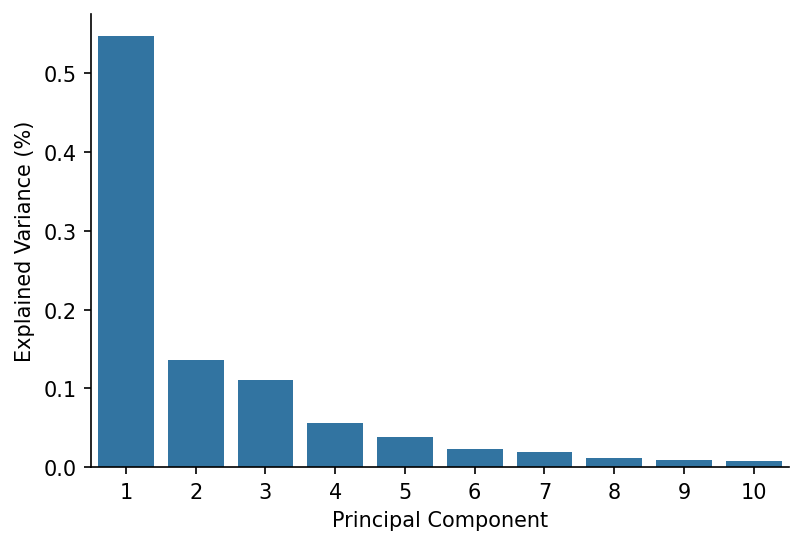

In [105]:
sns.barplot(x=np.arange(N_PCS) + 1, y=pca.explained_variance_ratio_, color=sns.color_palette()[0])
ax = plt.gca()
ax.set_ylabel("Explained Variance (%)")
ax.set_xlabel("Principal Component")
sns.despine()

## Track time

In [76]:
# convert to an xarray dataset to keep an eye on time
s = cfg["test_start_date"]
e = cfg["test_end_date"]
test = data.sel(station_id=int(station_id), time=slice(s, e))

times = test.time
time_deltas = sorted(pd.to_timedelta(np.arange(366), unit='d')[1:], reverse=True)

all_pcs = []
for ix in range(first_pcs.shape[-1]):
    pc = xr.Dataset(
        {f"pc{ix+1}": (["target_time", "time_delta"], np.squeeze(first_pcs[:, :, ix]))},
        coords={"target_time": times.values, "time_delta": time_deltas}
    )
    all_pcs.append(pc)
    
pcs = xr.merge(all_pcs)

In [77]:
time_vals = []
for ix in range(len(pcs.target_time.values)):
    time_vals.append(pcs.target_time.values[ix] - pc1.time_delta.values)
    
time_vals = np.array(time_vals)

In [89]:
actual_time = time_vals.flatten()
target_time = np.tile(pcs.target_time.values, 365)

all_pc_dfs = []
for pc_ix in range(first_pcs.shape[-1]):
    vals = np.squeeze(first_pcs[:, :, pc_ix]).flatten()
    
    pc_t = pd.DataFrame({f"pc{pc_ix+1}": vals, "actual_time": actual_time, "target_time":target_time})
    pc_t["doy"] = pc1_t["actual_time"].dt.dayofyear
    all_pc_dfs.append(pc_t)

### Compare the Seasonality of normalised PC of C_n vs Seasonality of Q

In [81]:
scaler = StandardScaler()
obs_discharge = scaler.fit_transform(data.sel(station_id=int(station_id), time=slice(s, e)).discharge_spec.values.reshape(-1, 1))
obs_q = pd.DataFrame({"time": times.values, "norm_discharge": obs_discharge.flatten()})
obs_q["doy"] = obs_q["time"].dt.dayofyear

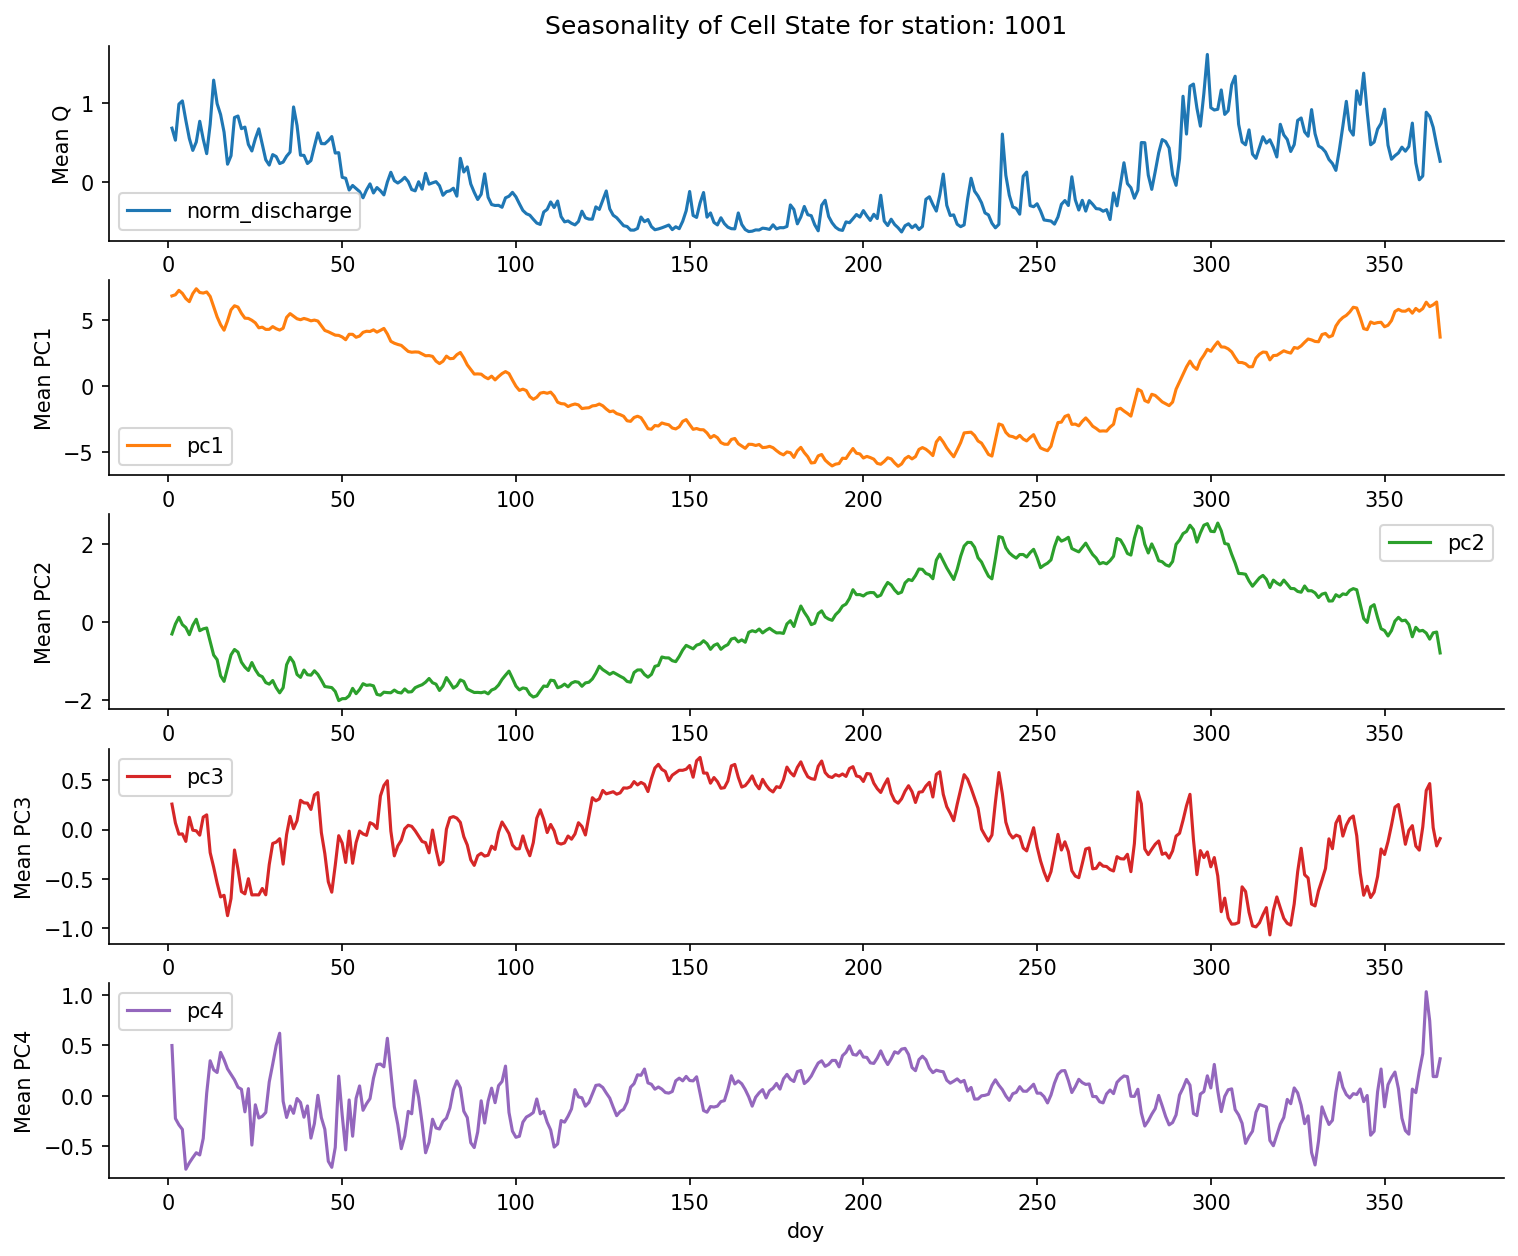

In [90]:
n_subplots = first_pcs.shape[-1] + 1

fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))

axs[0].set_title(f"Seasonality of Cell State for station: {station_id}")
obs_q.groupby("doy").mean().plot(ax=axs[0], color=sns.color_palette()[0])
axs[0].set_ylabel("Mean Q")

# Plot the 
for pc_ix in range(first_pcs.shape[-1]):
    d = all_pc_dfs[pc_ix]
    d.groupby("doy").mean().plot(ax=axs[pc_ix + 1], color=sns.color_palette()[pc_ix + 1])
    axs[pc_ix + 1].set_ylabel(f"Mean PC{pc_ix + 1}")

sns.despine()